### Cal-CRAI metric calculation: soil quality
* Mean evaporative stress index
* Mean surface soil moisture anomaly (depending on structure)

In [1]:
import pandas as pd
import os
import sys
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

### Metric 1
Mean evaporative stress index

In [2]:
evap_stress_link = 's3://ca-climate-index/2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa/evaporative_stress_ca_reproject.zarr/'

In [3]:
ds = xr.open_zarr(evap_stress_link)

# grab variable and load into memory
esi = ds['esi']
esi = esi.compute()
esi

<xarray.DataArray 'esi' (time: 418, lat: 191, lon: 208)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 42.02 41.97 41.92 41.87 ... 32.67 32.62 32.57 32.52
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
  * time     (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
Attributes:
    cell_methods:        time: mean
    comment:             12-week mean composite estimate of evaporative stres...
    composite_interval:  12 week
    grid_mapping:        spatial_ref
    long_name:           evaporative_stress_index
    units:               unitless

In [4]:
# determine how many values are extreme negative values -- are these outliers and can be safely removed?
esi.min().values, esi.max().values
# range is -25 to +5

# how many values are below ~ -5? (determining # of outliers)
outliers = (esi < -5).sum()
outliers

# 862 values below -5 (1 value below -25), keep!

<xarray.DataArray 'esi' ()>
array(862)

### Calculate metric
* mean evaporative stress index

In [5]:
# check difference between time mean and annual mean -- no difference
esi_ann = esi.groupby('time.year').mean()
esi_ann_avg = esi_ann.mean(dim='year')
esi_ann_avg.min().values, esi_ann_avg.max().values

(array(-4.09898567), array(2.46529722))

### Reproject data to census tract projection

In [6]:
df = esi_ann_avg.to_dataframe().reset_index()

In [7]:
unique_esi_entries = df['esi'].nunique()
print(f'There are {unique_esi_entries} unique entries in the esi column.')

There are 17159 unique entries in the esi column.


In [8]:
# Create geometry column from coordinates
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Create GeoDataFrame
esi_gdf = gpd.GeoDataFrame(df, geometry=geometry)
esi_gdf

,lat,lon,esi,geometry
0,42.025,-124.475,NaN,POINT (-124.475 42.025)
1,42.025,-124.425,NaN,POINT (-124.425 42.025)
2,42.025,-124.375,NaN,POINT (-124.375 42.025)
3,42.025,-124.325,NaN,POINT (-124.325 42.025)
4,42.025,-124.275,NaN,POINT (-124.275 42.025)
...,...,...,...,...
39723,32.525,-114.325,NaN,POINT (-114.325 32.525)
39724,32.525,-114.275,NaN,POINT (-114.275 32.525)
39725,32.525,-114.225,NaN,POINT (-114.225 32.525)
39726,32.525,-114.175,NaN,POINT (-114.175 32.525)


<Axes: >

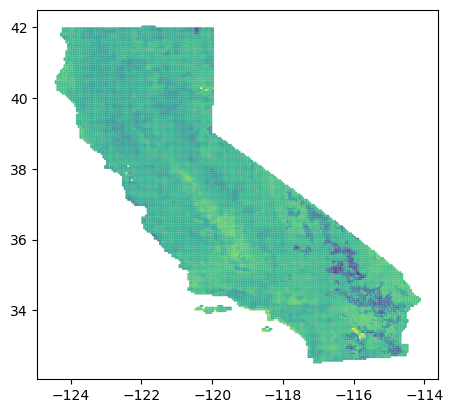

In [9]:
esi_gdf.plot(column='esi', markersize=0.25)

In [10]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
print("ca_boundaries CRS:", ca_boundaries.crs)

ca_boundaries CRS: EPSG:4269


In [11]:
# Check the current CRS of the GeoDataFrame
print("gdf CRS:", esi_gdf.crs)
esi_gdf.set_crs(epsg="4269", inplace=True)

# If they have different CRS, transform one to match the other
if esi_gdf.crs != ca_boundaries.crs:
    esi_gdf = esi_gdf.to_crs(ca_boundaries.crs)

# Now both GeoDataFrames should have the same CRS
print("Transformed gdf CRS:", esi_gdf.crs)

gdf CRS: None
Transformed gdf CRS: EPSG:4269


/Users/victoriaford/anaconda3/envs/carb/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


<Axes: >

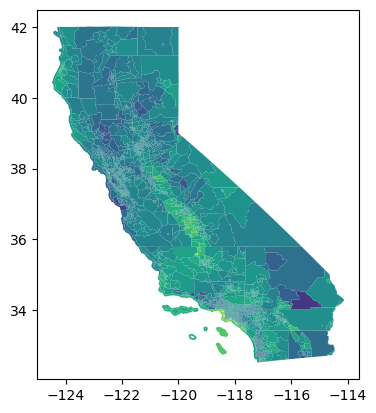

In [16]:
# intersect points within geometry -- warning popping up about CRS -- ignore since they are in the same projection
intersect_df = gpd.sjoin_nearest(esi_gdf, ca_boundaries, how='right', max_distance=10)
intersect_df_avg = intersect_df.groupby('GEOID')['esi'].agg(['mean']).reset_index()
intersect_df_avg = pd.merge(intersect_df_avg, ca_boundaries, on='GEOID', how='right')
intersect_df_avg = gpd.GeoDataFrame(intersect_df_avg, geometry='geometry')

# reanme column to be interpretable
intersect_df_avg['esi_mean'] = intersect_df_avg['mean']
intersect_df_avg.plot(column='esi_mean')

In [17]:
# drop unneeded columns
intersect_df_avg = intersect_df_avg[['GEOID', 'esi_mean']]
intersect_df_avg

,GEOID,esi_mean
0,06085504321,-0.256612
1,06085504410,-0.248534
2,06085507003,-0.006297
3,06085507004,-0.066103
4,06085502204,0.020351
...,...,...
9124,06059001303,-0.115281
9125,06059001304,-0.052832
9126,06059001401,-0.052832
9127,06013367200,-0.141686


In [19]:
# save as a csv
intersect_df_avg.to_csv('natural_crop_condition_esi_metric.csv', index=False)

### Metric 2
* Mean surface soil moisture anomaly

In [20]:
soil_anom_link = 's3://ca-climate-index/2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa/soil_moisture_anom_ca_reproject.zarr/'

In [21]:
ds = xr.open_zarr(soil_anom_link)

# grab variable and load into memory
ssma = ds['ssma']
ssma = ssma.compute()
ssma

<xarray.DataArray 'ssma' (time: 889, lat: 86, lon: 93)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 42.04 41.93 41.81 41.7 ... 32.82 32.7 32.59 32.48
  * lon      (lon) float64 -124.5 -124.4 -124.3 -124.1 ... -114.4 -114.2 -114.1
  * time     (time) datetime64[ns] 2015-04-03T12:00:00 ... 2022-08-03T12:00:00
Attributes:
    cell_methods:        time: mean
    comment:             3 day mean composite estimate
    composite_interval:  3 day
    grid_mapping:        spatial_ref
    long_name:           surface_soil_moisture_anomaly
    units:               unitless

In [22]:
ssma.min().values, ssma.max().values

(array(-4.), array(4.))

### Calculate metric

In [23]:
ssma_ann = ssma.groupby('time.year').mean()
ssma_ann_avg = ssma_ann.mean(dim='year')
ssma_ann_avg.min().values, ssma_ann_avg.max().values

(array(-0.74255216), array(0.20326817))

### Reproject to census tracts

In [24]:
df = ssma_ann_avg.to_dataframe().reset_index()

In [25]:
# Create geometry column from coordinates
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Create GeoDataFrame
ssma_gdf = gpd.GeoDataFrame(df, geometry=geometry)
ssma_gdf

,lat,lon,ssma,geometry
0,42.037643,-124.480687,NaN,POINT (-124.48069 42.03764)
1,42.037643,-124.368223,NaN,POINT (-124.36822 42.03764)
2,42.037643,-124.255759,NaN,POINT (-124.25576 42.03764)
3,42.037643,-124.143294,NaN,POINT (-124.14329 42.03764)
4,42.037643,-124.030830,NaN,POINT (-124.03083 42.03764)
...,...,...,...,...
7993,32.478172,-114.583824,NaN,POINT (-114.58382 32.47817)
7994,32.478172,-114.471359,NaN,POINT (-114.47136 32.47817)
7995,32.478172,-114.358895,NaN,POINT (-114.35889 32.47817)
7996,32.478172,-114.246430,NaN,POINT (-114.24643 32.47817)


<Axes: >

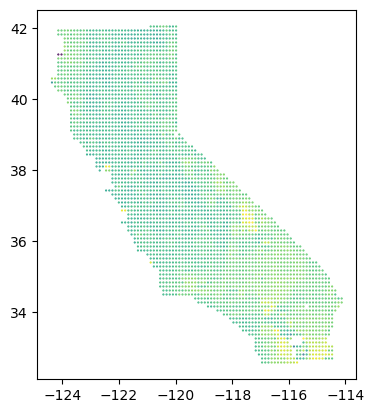

In [31]:
ssma_gdf.plot(column='ssma', markersize=0.25)

In [27]:
# Check the current CRS of the GeoDataFrame
print("gdf CRS:", ssma_gdf.crs)
ssma_gdf.set_crs(epsg="4269", inplace=True)

# If they have different CRS, transform one to match the other
if ssma_gdf.crs != ca_boundaries.crs:
    ssma_gdf = ssma_gdf.to_crs(ca_boundaries.crs)

# Now both GeoDataFrames should have the same CRS
print("Transformed gdf CRS:", ssma_gdf.crs)

gdf CRS: None
Transformed gdf CRS: EPSG:4269


/Users/victoriaford/anaconda3/envs/carb/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


<Axes: >

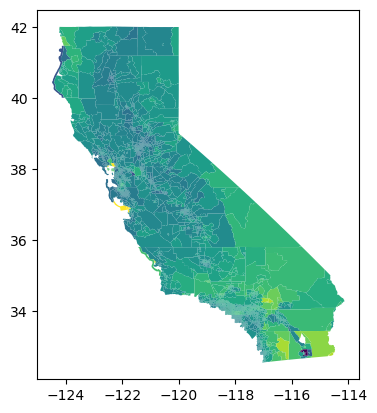

In [30]:
# intersect points within geometry -- warning popping up about CRS -- ignore since they are in the same projection
intersect_df = gpd.sjoin_nearest(ssma_gdf, ca_boundaries, how='right', max_distance=10)
intersect_ssma_avg = intersect_df.groupby('GEOID')['ssma'].agg(['mean']).reset_index()
intersect_ssma_avg = pd.merge(intersect_ssma_avg, ca_boundaries, on='GEOID', how='right')
intersect_ssma_avg = gpd.GeoDataFrame(intersect_ssma_avg, geometry='geometry')

# reanme column to be interpretable
intersect_ssma_avg['ssma_mean'] = intersect_ssma_avg['mean']
intersect_ssma_avg.plot(column='ssma_mean')

In [32]:
# drop unneeded columns
intersect_ssma_avg = intersect_ssma_avg[['GEOID', 'ssma_mean']]
intersect_ssma_avg

,GEOID,ssma_mean
0,06085504321,-0.150536
1,06085504410,-0.150536
2,06085507003,-0.182977
3,06085507004,-0.182977
4,06085502204,-0.163483
...,...,...
9124,06059001303,-0.031379
9125,06059001304,-0.031379
9126,06059001401,-0.031379
9127,06013367200,0.007191


In [33]:
# save as a csv
intersect_ssma_avg.to_csv('natural_crop_condition_soil_anomaly_metric.csv', index=False)

### Step 4: Metadata

In [34]:
@append_metadata
def natural_soil_quality(input_csv, export=False, varname=''):    
    '''
    Calculates the average soil quality / crop condition values per California census tract.
    Metrics are:
    * Mean evaporative stress index
    * Mean surface soil moisture anomaly
    Data was sourced from: https://climateserv.servirglobal.net/map

    Methods
    -------
    Data columns were renamed, merged to 2022 census tract data, and averaged to attribute
    scores to all California tracts.
    
    Parameters
    ----------
    df: string
        the dataframe containing the crop condition data
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI crop condition metric to AWS
        True = will upload resulting df containing CAL CRAI crop condition metric to AWS
    import_csv: string
        name of the csv file to be uploaded to AWS

    Script
    ------
    natural_soil_quality.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are
    stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: data converted to Cal-CRAI standardized coordinate reference system (CRS): 4269.')
    print('Data transformation: merge data to California tracts and calculate census tract average over time.')
    print('Data transformation: nan values are retained for each census tract without a soil quality metric(s), especially relevant for urban areas.')

    bucket_name = 'ca-climate-index'
    directory = '3_fair_data/index_data'
    export_filename = [input_csv]

    if export == True:
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{export_filename} uploaded to AWS.')

    if os.path.exists(input_csv):
        os.remove(input_csv)

In [35]:
input_csv = ['natural_crop_condition_esi_metric.csv',
            'natural_crop_condition_soil_anomaly_metric.csv']

varnames = [
    'natural_nasa_crop_esi',
    'natural_nasa_soil_moisture_anomaly']

for csv, var in zip(input_csv, varnames):
    natural_soil_quality(csv, export=False, varname=var)